In [1]:
!nvidia-smi

Sun Aug  9 04:42:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -U tensorflow -q

In [3]:
!pip uninstall keras-applications --yes

In [4]:
!pip install git+https://github.com/keras-team/keras-applications.git@master

  Cloning https://github.com/keras-team/keras-applications.git (to revision master) to /tmp/pip-req-build-6_6g1hge
  Running command git clone -q https://github.com/keras-team/keras-applications.git /tmp/pip-req-build-6_6g1hge
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-cp36-none-any.whl size=62000 sha256=b4601774cb10ef1d5798899de8b9eb2e51223140ee4a7746b1f71494c203f8df
  Stored in directory: /tmp/pip-ephem-wheel-cache-z3q0bmg9/wheels/f8/3c/48/007f19c86cc5d5f276a748f003a63bc19558539eab93afb545
Successfully built Keras-Applications


In [7]:
from keras_applications import mobilenet_v3

In [8]:
import tensorflow as tf
import numpy as np

In [9]:
import cv2
import matplotlib.pyplot as plt

In [10]:
base_model = mobilenet_v3.MobileNetV3Small(input_shape=(None, None, 3),
                              alpha=0.75,
                              minimalistic=False,
                              include_top=False,
                              weights="imagenet",
                              backend=tf.keras.backend,
                              layers=tf.keras.layers,
                              models=tf.keras.models,
                              utils=tf.keras.utils
                              )

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v3.py:348: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


2850816/2843184 [==============================] - 1s 0us/step


In [45]:
base_model.trainable = False

In [12]:
out = base_model.predict(np.random.randn(1,320,320,3))
out.shape

(1, 10, 10, 432)

In [13]:
num_classes = 1

In [14]:
inputs = tf.keras.Input(shape=(None, None, 3))
sf = base_model(inputs, training=False)
sf = tf.keras.layers.Conv2D(128, kernel_size=1, strides=1)(sf)
sf = tf.keras.layers.Activation(mobilenet_v3.hard_swish)(sf)
sf = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(sf)
sf = tf.keras.layers.Activation(mobilenet_v3.hard_swish)(sf)
sf = tf.keras.layers.Conv2D(num_classes, kernel_size=1, strides=1)(sf)
# sf = tf.keras.layers.Activation('sigmoid')(sf)
sf.shape

TensorShape([None, None, None, 1])

In [17]:
model = tf.keras.models.Model(inputs, outputs=sf)

In [18]:
model.summary()

Model: "functional_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
MobilenetV3small (Functional (None, None, None, 432)   583160    
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 128)   55424     
_________________________________________________________________
activation_32 (Activation)   (None, None, None, 128)   0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, None, None, 64)    73792     
_________________________________________________________________
activation_33 (Activation)   (None, None, None, 64)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 1)    

In [19]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [71]:
out = model.predict(np.random.randn(1,320,320,3))
out.shape

(1, 20, 20, 1)

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [22]:
BATCH_SIZE = 64
IMG_HEIGHT = 320
IMG_WIDTH = 320
OUT_HEIGHT = 20
OUT_WIDTH = 20

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [24]:
!cp /content/drive/My\ Drive/garbage_dataset.zip /content/

In [25]:
!unzip -q garbage_dataset.zip

In [26]:
list_ds = tf.data.Dataset.list_files("garbage_dataset/train/*")
valid_ds = tf.data.Dataset.list_files("garbage_dataset/test/*")

In [27]:
LEN_DS = len(list(list_ds))

In [28]:
for f in list_ds.take(1):
    print(f)

tf.Tensor(b'garbage_dataset/train/38b3f02e-9447-11e5-9ae8-40f2e96c8ad8.jpg', shape=(), dtype=string)


In [29]:
import pickle
with open('labels.pickle', 'rb') as f:
    lbls = pickle.load(f)

In [30]:
def get_label(file_path):
    parts = tf.strings.split(file_path, '/')
    label = lbls[parts[-1].numpy().decode()]
    label = tf.convert_to_tensor(label, tf.float32)
    return label

In [31]:
get_label_wrapper = lambda x: tf.py_function(get_label, [x], tf.float32)

In [32]:
def decode_img(img):
    img = tf.io.decode_image(img, channels=3, expand_animations = False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    return img*2 - 1

In [33]:
def process_path(file_path):
    label = get_label_wrapper(file_path)
    label.set_shape([OUT_HEIGHT, OUT_WIDTH, num_classes])
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [34]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_test_ds = valid_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [35]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy().shape)

Image shape:  (320, 320, 3)
Label:  (20, 20, 1)


In [36]:
image.numpy().min()

-1.0

In [37]:
def prepare_for_training(ds, cache=True):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat() #repeat forever
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [38]:
train_ds = prepare_for_training(labeled_ds)
test_ds = prepare_for_training(labeled_test_ds)

In [39]:
def lr_scheduler(epoch, lr):
    if not epoch % 4 and epoch:
        return lr/2
    return lr
lrsc = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

In [40]:
history = model.fit(train_ds,
                    epochs=15,
                    steps_per_epoch=40,
                    validation_data=test_ds,
                    validation_steps=6,
                    callbacks=[lrsc])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
40/40 [==============================] - 52s 1s/step - loss: 0.2745 - accuracy: 0.9136 - val_loss: 0.1888 - val_accuracy: 0.9282

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/15
40/40 [==============================] - 3s 70ms/step - loss: 0.1644 - accuracy: 0.9352 - val_loss: 0.1595 - val_accuracy: 0.9354

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/15
40/40 [==============================] - 3s 72ms/step - loss: 0.1418 - accuracy: 0.9420 - val_loss: 0.1575 - val_accuracy: 0.9353

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/15
40/40 [==============================] - 3s 70ms/step - loss: 0.1307 - accuracy: 0.9453 - val_loss: 0.1449 - val_accuracy: 0.9409

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
Epoch 5/15
4

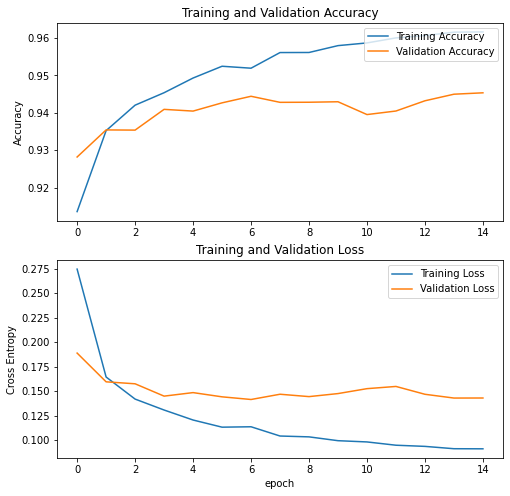

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
for lyr in base_model.layers[-52:]:
    lyr.trainable=True

In [67]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [68]:
history_fine = model.fit(train_ds,
                         epochs=20,
                         steps_per_epoch=40,
                        #  initial_epoch = history.epoch[-1]+1,
                         validation_data=test_ds,
                         validation_steps=6,
                         callbacks=[lrsc])


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 1/20
40/40 [==============================] - 4s 89ms/step - loss: 0.0663 - accuracy: 0.9724 - val_loss: 0.1888 - val_accuracy: 0.9394

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 2/20
40/40 [==============================] - 3s 71ms/step - loss: 0.0653 - accuracy: 0.9731 - val_loss: 0.1760 - val_accuracy: 0.9433

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 3/20
40/40 [==============================] - 3s 70ms/step - loss: 0.0646 - accuracy: 0.9733 - val_loss: 0.1877 - val_accuracy: 0.9404

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 4/20
40/40 [==============================] - 3s 70ms/step - loss: 0.0634 - accuracy: 0.9737 - val_loss: 0.1862 - val_accuracy: 0.9408

Epoch 00005: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 5/20


In [69]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

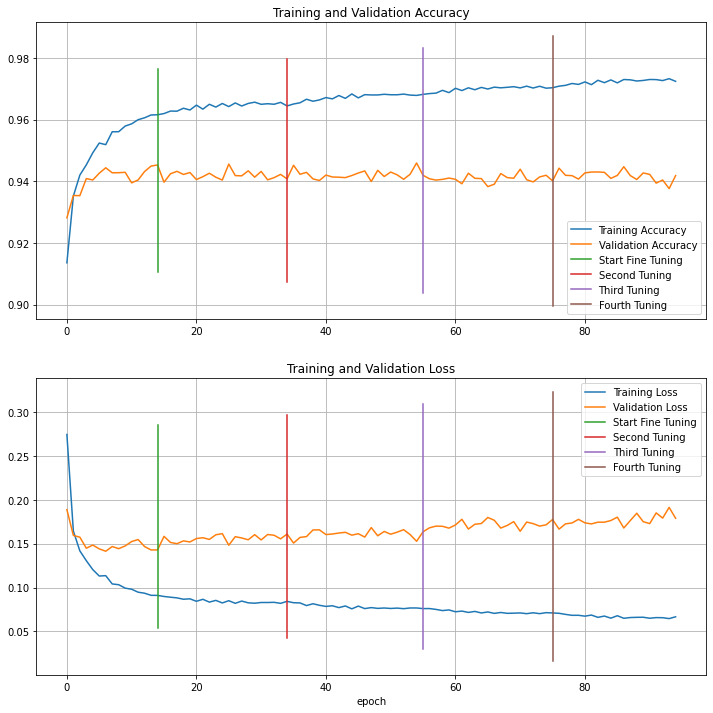

In [73]:
initial_epochs = history.epoch[-1]
second_tune = 35-1
third_tune = 55
fourth_tune = 75
fifth_tune = 95

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc[:95], label='Training Accuracy')
plt.plot(val_acc[:95], label='Validation Accuracy')
# plt.ylim([0.7, 1])
plt.plot([initial_epochs,initial_epochs], plt.ylim(), label='Start Fine Tuning')
plt.plot([second_tune,second_tune], plt.ylim(), label='Second Tuning')
plt.plot([third_tune,third_tune], plt.ylim(), label='Third Tuning')
plt.plot([fourth_tune,fourth_tune], plt.ylim(), label='Fourth Tuning')
# plt.plot([fifth_tune,fifth_tune], plt.ylim(), label='Fifth Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss[:95], label='Training Loss')
plt.plot(val_loss[:95], label='Validation Loss')
# plt.ylim([0, 0.8])
plt.plot([initial_epochs,initial_epochs], plt.ylim(), label='Start Fine Tuning')
plt.plot([second_tune,second_tune], plt.ylim(), label='Second Tuning')
plt.plot([third_tune,third_tune], plt.ylim(), label='Third Tuning')
plt.plot([fourth_tune,fourth_tune], plt.ylim(), label='Fourth Tuning')
# plt.plot([fifth_tune,fifth_tune], plt.ylim(), label='Fifth Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [51]:
for lyr in base_model.layers[-84:]:
    lyr.trainable=True

In [56]:
for lyr in base_model.layers[-100:]:
    lyr.trainable=True

In [61]:
for lyr in base_model.layers[-132:]:
    lyr.trainable=True

In [66]:
for lyr in base_model.layers:
    lyr.trainable=True

In [98]:
model.save("/content/drive/My Drive/non_sig_model_0_75_-1to1")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/non_sig_model_0_75_-1to1/assets


In [75]:
import os
import random

In [92]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

In [101]:
TDIR = "garbage_dataset/train/"
tsfiles = os.listdir(TDIR)
samples = random.sample(tsfiles,20)
samples = tsfiles[:100]
for fp in samples:
    img = cv2.imread(TDIR+fp)
    try:
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    except:
        continue
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB).astype(np.float32)
    img = img/127.5 - 1
    pred = model.predict(np.expand_dims(img,0)).squeeze()
    # print(pred.max())
    pred[pred<2.5] = -10
    pred = sigmoid(pred)
    mask = cv2.resize(pred, img.shape[1::-1])
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow((img+1)/2)
    # plt.show()
    plt.imshow(mask, alpha=0.4)
    plt.savefig("/content/drive/My Drive/detect_out/out_"+fp, bbox_inches='tight')
    # plt.show()
    plt.close()